Notebook to predict the Aboveground Biomass (AGB) of banana trees using ResNet-18 model.


Author: Payel Mukhopadhyay

In [158]:
from __future__ import print_function, division
import os
import time
import torch
import torch.nn as nn
from  torch import optim 
import pandas as pd
from skimage import io, transform
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.modules.loss import BCEWithLogitsLoss
from torchvision.transforms.functional import pad
import cv2
import torchvision
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from torchvision import transforms
from torchvision import models
#from torchmetrics.classification import BinaryPrecision
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [159]:
# Read into csv file
final = pd.read_csv('mapping/final_dataset.csv')

In [160]:
final_bananas = final.loc[final['group'] == 'banana']

In [161]:
final_bananas

img_path         xmin  \
0       Carlos_Vera_Guevara_RGB_3_0_8305_4000_12305.png  3332.557861   
1       Carlos_Vera_Guevara_RGB_3_0_8305_4000_12305.png  3162.579834   
2       Carlos_Vera_Guevara_RGB_3_0_8305_4000_12305.png  2893.605713   
3       Carlos_Vera_Guevara_RGB_3_0_8305_4000_12305.png  2595.111084   
4     Carlos_Vera_Guevara_RGB_10_7600_7600_11600_116...   249.691879   
...                                                 ...          ...   
1499     Nestor_Macias_RGB_10_7600_7600_11600_11600.png  3008.032715   
1500     Nestor_Macias_RGB_10_7600_7600_11600_11600.png  2669.628662   
1501     Nestor_Macias_RGB_10_7600_7600_11600_11600.png   546.010803   
1502     Nestor_Macias_RGB_10_7600_7600_11600_11600.png  1223.366211   
1503     Nestor_Macias_RGB_10_7600_7600_11600_11600.png  3802.105713   

             ymin         xmax         ymax     score  \
0       19.092411  3661.390137   364.616425  0.531211   
1     2148.233398  3431.632324  2379.467041  0.511510   
2      244.011108  3095.620605   451.257812  0.251310   
3     1703.712402  2765.227295  1865.253418  0.217742   
4      123.626862   439.557648   302.768402  0.282849   
...           ...          ...          ...       ...   
1499  2948.086426  3279.174561  3205.857178  0.255504   
1500  1073.352905  2904.145264  1306.345703  0.242106   
1501  3563.106934   742.531189  3742.397461  0.224946   
1502   679.579102  1410.007202   877.788940  0.216676   
1503     1.835251  4000.000000   197.081696  0.201453   

                     img_name  tile_index  tile_xmin  tile_ymin  ...  \
0     Carlos_Vera_Guevara_RGB           3          0       8305  ...   
1     Carlos_Vera_Guevara_RGB           3          0       8305  ...   
2     Carlos_Vera_Guevara_RGB           3          0       8305  ...   
3     Carlos_Vera_Guevara_RGB           3          0       8305  ...   
4     Carlos_Vera_Guevara_RGB          10       7600       7600  ...   
...                       ...         ...        ...        ...  ...   
1499        Nestor_Macias_RGB          10       7600       7600  ...   
1500        Nestor_Macias_RGB          10       7600       7600  ...   
1501        Nestor_Macias_RGB          10       7600       7600  ...   
1502        Nestor_Macias_RGB          10       7600       7600  ...   
1503        Nestor_Macias_RGB          10       7600       7600  ...   

      is_musacea_g                     site          X_g          Y_g  \
0              1.0  Carlos_Vera_Guevara_RGB  5298.555843  7709.844671   
1              1.0  Carlos_Vera_Guevara_RGB  5315.345160  8606.745732   
2              1.0  Carlos_Vera_Guevara_RGB  5228.142461  7935.770200   
3              1.0  Carlos_Vera_Guevara_RGB  4434.058601  8354.081799   
4              1.0  Carlos_Vera_Guevara_RGB  8257.952942  7554.538338   
...            ...                      ...          ...          ...   
1499           1.0        Nestor_Macias_RGB  9623.242137  8101.598810   
1500           1.0        Nestor_Macias_RGB  9270.721398  7827.248448   
1501           1.0        Nestor_Macias_RGB  7966.574575  9095.186414   
1502           1.0        Nestor_Macias_RGB  8814.804453  7427.844880   
1503           1.0        Nestor_Macias_RGB  9783.786707  7350.761546   

      updated diameter   group  updated height        AGB    carbon   id  
0            10.281385  banana             0.0   4.293300  1.674387   30  
1            13.528139  banana             0.0   7.702971  3.004159  112  
2            12.732366  banana             0.0   6.769828  2.640233  179  
3             9.867583  banana             0.0   3.933601  1.534104   93  
4            17.825312  banana             0.0  13.862143  5.406236  162  
...                ...     ...             ...        ...       ...  ...  
1499         14.323911  banana             0.0   8.700266  3.393104  240  
1500         16.870385  banana             0.0  12.328137  4.807974  109  
1501         17.507003  banana             0.0  13.340202  5.202679  317  
1502 

In [162]:
final_bananas_random = final_bananas.sample(1504)
final_bananas_random

img_path         xmin  \
835           Leonor_Aspiazu_RGB_1_0_3800_4000_7800.png     3.806969   
1145          Nestor_Macias_RGB_2_0_7600_4000_11600.png  3483.235840   
409         Flora_Pluas_RGB_11_7600_3800_11600_7800.png  2239.033936   
66    Carlos_Vera_Guevara_RGB_6_3800_7600_7800_11600...  1621.661377   
241   Carlos_Vera_Arteaga_RGB_13_11297_3800_15297_78...  2128.116211   
...                                                 ...          ...   
347   Carlos_Vera_Arteaga_RGB_13_11297_3800_15297_78...   898.234375   
716       Flora_Pluas_RGB_22_12782_7600_16782_11600.png   155.875763   
548         Flora_Pluas_RGB_9_3800_11578_7800_15578.png   864.038147   
1193        Nestor_Macias_RGB_12_11003_0_15003_4000.png  1459.660522   
596           Flora_Pluas_RGB_6_3800_3800_7800_7800.png  2820.129395   

             ymin         xmax         ymax     score  \
835   2827.680420   174.034042  3044.669189  0.209769   
1145  2694.406738  3810.904297  3039.304688  0.602500   
409   3077.146973  2636.738525  3486.297852  0.569085   
66     348.530396  1855.036865   582.852051  0.560293   
241      5.058767  2366.794189   119.393768  0.216115   
...           ...          ...          ...       ...   
347   1800.864502  1083.435425  1972.776611  0.300719   
716   2577.795410   333.079803  2752.884766  0.473371   
548     45.340622  1148.984985   352.433136  0.402362   
1193  3789.109375  1789.663330  3992.705322  0.448350   
596    497.502472  3132.039551   831.552429  0.595481   

                     img_name  tile_index  tile_xmin  tile_ymin  ...  \
835        Leonor_Aspiazu_RGB           1          0       3800  ...   
1145        Nestor_Macias_RGB           2          0       7600  ...   
409           Flora_Pluas_RGB          11       7600       3800  ...   
66    Carlos_Vera_Guevara_RGB           6       3800       7600  ...   
241   Carlos_Vera_Arteaga_RGB          13      11297       3800  ...   
...                       ...         ...        ...        ...  ...   
347   Carlos_Vera_Arteaga_RGB          13      11297       3800  ...   
716           Flora_Pluas_RGB          22      12782       7600  ...   
548           Flora_Pluas_RGB           9       3800      11578  ...   
1193        Nestor_Macias_RGB          12      11003          0  ...   
596           Flora_Pluas_RGB           6       3800       3800  ...   

      is_musacea_g                     site           X_g          Y_g  \
835            1.0       Leonor_Aspiazu_RGB   3862.628827  7379.638339   
1145           1.0        Nestor_Macias_RGB   5159.743280  8607.924422   
409            1.0          Flora_Pluas_RGB   9581.846067  6150.008202   
66             1.0  Carlos_Vera_Guevara_RGB   6612.498036  7778.786894   
241            1.0  Carlos_Vera_Arteaga_RGB  10700.244240  3172.823219   
...            ...                      ...           ...          ...   
347            1.0  Carlos_Vera_Arteaga_RGB  10139.743035  4228.720919   
716            1.0          Flora_Pluas_RGB  11509.736392  7629.544282   
548            1.0          Flora_Pluas_RGB   6105.494580  8285.242524   
1193           1.0        Nestor_Macias_RGB  10591.377749  5806.297477   
596            1.0          Flora_Pluas_RGB   7494.059624  4540.787527   

      updated diameter   group  updated height        AGB    carbon   id  
835          16.233766  banana             0.0  11.358326  4.429747   83  
1145          9.549274  banana             0.0   3.668243  1.430615  172  
409          18.652916  banana             0.0  15.269042  5.954926  388  
66           13.368984  banana             0.0   7.511226  2.929378  152  
241           9.867583  banana             0.0   3.933601  1.534104  142  
...                ...     ...             ...        ...       ...  ...  
347           8.276038  banana             0.0   2.704476  1.054746   86  
716          11.777438  banana             0.0   5.734024  2.236270  251  
548          18.461930  banana             0.0  14.937967  5.825807 

In [208]:
# Make train, test, validation splits
trees_train_1, trees_test = train_test_split(final_bananas_random, shuffle = True, test_size = 0.15, 
                                           stratify=final_bananas_random.site.values)

In [209]:
trees_train, trees_valid = train_test_split(trees_train_1, shuffle = True, test_size = 0.2, 
                                           stratify=trees_train_1.site.values)

In [210]:
trees_train

img_path         xmin  \
377   Carlos_Vera_Arteaga_RGB_6_3800_7600_7800_11600...  3329.556152   
1043      Manuel_Macias_RGB_8_7600_6879_11600_10879.png  1370.117188   
1074       Manuel_Macias_RGB_5_3800_6879_7800_10879.png  2133.211426   
318   Carlos_Vera_Arteaga_RGB_9_7600_3800_11600_7800...  2087.394531   
1250       Nestor_Macias_RGB_7_3800_9024_7800_13024.png  2214.100098   
...                                                 ...          ...   
8       Carlos_Vera_Guevara_RGB_8_7600_0_11600_4000.png   289.777344   
851          Leonor_Aspiazu_RGB_3_0_9855_4000_13855.png  1484.867432   
604           Flora_Pluas_RGB_6_3800_3800_7800_7800.png  1162.803101   
48    Carlos_Vera_Guevara_RGB_5_3800_3800_7800_7800.png  1227.715698   
509        Flora_Pluas_RGB_21_12782_3800_16782_7800.png   978.659180   

             ymin         xmax         ymax     score  \
377    325.651093  3571.834473   553.526978  0.204065   
1043  1126.871948  1635.767456  1396.043945  0.454125   
1074  1605.312988  2607.341064  2061.249756  0.489381   
318   3400.796387  2268.294189  3568.887207  0.239078   
1250  3155.679688  2683.022461  3616.820312  0.463756   
...           ...          ...          ...       ...   
8     1570.390015   562.296753  1841.121460  0.384207   
851     60.001400  1955.621826   550.741760  0.523032   
604    758.386353  1488.264893  1091.547485  0.537306   
48    2001.774902  1429.226685  2185.284424  0.311006   
509   2964.686523  1353.210938  3365.102295  0.624866   

                     img_name  tile_index  tile_xmin  tile_ymin  ...  \
377   Carlos_Vera_Arteaga_RGB           6       3800       7600  ...   
1043        Manuel_Macias_RGB           8       7600       6879  ...   
1074        Manuel_Macias_RGB           5       3800       6879  ...   
318   Carlos_Vera_Arteaga_RGB           9       7600       3800  ...   
1250        Nestor_Macias_RGB           7       3800       9024  ...   
...                       ...         ...        ...        ...  ...   
8     Carlos_Vera_Guevara_RGB           8       7600          0  ...   
851        Leonor_Aspiazu_RGB           3          0       9855  ...   
604           Flora_Pluas_RGB           6       3800       3800  ...   
48    Carlos_Vera_Guevara_RGB           5       3800       3800  ...   
509           Flora_Pluas_RGB          21      12782       3800  ...   

      is_musacea_g                     site           X_g           Y_g  \
377            1.0  Carlos_Vera_Arteaga_RGB   6890.214156   7936.951645   
1043           1.0        Manuel_Macias_RGB   9465.540438   7928.702458   
1074           1.0        Manuel_Macias_RGB   8188.912055   7981.297656   
318            1.0  Carlos_Vera_Arteaga_RGB   8560.197671   6646.434769   
1250           1.0        Nestor_Macias_RGB   6808.685230  10656.952790   
...            ...                      ...           ...           ...   
8              1.0  Carlos_Vera_Guevara_RGB   7454.100753   4084.694864   
851            1.0       Leonor_Aspiazu_RGB   4598.289417   8738.874024   
604            1.0          Flora_Pluas_RGB   6628.891986   4800.618637   
48             1.0  Carlos_Vera_Guevara_RGB   6003.605440   6431.152756   
509            1.0          Flora_Pluas_RGB  12765.816082   6468.849844   

      updated diameter   group  updated height        AGB    carbon   id  
377          12.732366  banana             0.0   6.769828  2.640233  192  
1043          2.387319  banana             0.0   0.191457  0.074668   45  
1074         17.507003  banana             0.0  13.340202  5.202679   96  
318          17.125032  banana             0.0  12.727881  4.963874    3  
1250          7.034632  banana             0.0   1.913134  0.746122  192  
...                ...     ...             ...        ...       ...  ...  
8            15.437993  banana             0.0  10.205159  3.980012  142  
851           7.957729  banana             0.0   2.487723  0.970212   89  
604          16.934046  banana             0.0  12.42743

In [211]:
trees_valid

img_path         xmin  \
196      Carlos_Vera_Arteaga_RGB_1_0_3800_4000_7800.png  1132.666626   
575            Flora_Pluas_RGB_10_7600_0_11600_4000.png   396.902161   
328   Carlos_Vera_Arteaga_RGB_10_7600_7600_11600_116...  2898.165283   
1423       Nestor_Macias_RGB_9_7600_3800_11600_7800.png  1319.796875   
612           Flora_Pluas_RGB_6_3800_3800_7800_7800.png  1661.033813   
...                                                 ...          ...   
1060        Manuel_Macias_RGB_4_3800_3800_7800_7800.png  2063.157959   
46    Carlos_Vera_Guevara_RGB_5_3800_3800_7800_7800.png  1883.142212   
1304       Nestor_Macias_RGB_6_3800_7600_7800_11600.png  3047.582275   
301      Carlos_Vera_Arteaga_RGB_1_0_3800_4000_7800.png  3212.613037   
620           Flora_Pluas_RGB_6_3800_3800_7800_7800.png  1422.161255   

             ymin         xmax         ymax     score  \
196   2975.641846  1360.982300  3220.118408  0.283619   
575   1637.752563   785.161133  2061.031982  0.698681   
328    752.639221  3147.275879   982.602661  0.232791   
1423  1878.027832  1545.933472  2131.083984  0.426528   
612   2623.463623  1984.506836  2930.449463  0.490506   
...           ...          ...          ...       ...   
1060  3247.853027  2365.514893  3558.620850  0.355894   
46    1910.511719  2195.064697  2245.461426  0.356164   
1304  3421.514160  3284.467041  3676.903076  0.576454   
301   2234.093994  3657.874756  2694.325684  0.380553   
620   2455.968506  1667.221069  2711.201172  0.410879   

                     img_name  tile_index  tile_xmin  tile_ymin  ...  \
196   Carlos_Vera_Arteaga_RGB           1          0       3800  ...   
575           Flora_Pluas_RGB          10       7600          0  ...   
328   Carlos_Vera_Arteaga_RGB          10       7600       7600  ...   
1423        Nestor_Macias_RGB           9       7600       3800  ...   
612           Flora_Pluas_RGB           6       3800       3800  ...   
...                       ...         ...        ...        ...  ...   
1060        Manuel_Macias_RGB           4       3800       3800  ...   
46    Carlos_Vera_Guevara_RGB           5       3800       3800  ...   
1304        Nestor_Macias_RGB           6       3800       7600  ...   
301   Carlos_Vera_Arteaga_RGB           1          0       3800  ...   
620           Flora_Pluas_RGB           6       3800       3800  ...   

      is_musacea_g                     site          X_g          Y_g  \
196            1.0  Carlos_Vera_Arteaga_RGB  4511.798463  8124.335052   
575            1.0          Flora_Pluas_RGB  7743.719816  3619.830592   
328            1.0  Carlos_Vera_Arteaga_RGB  8608.000694  7367.560092   
1423           1.0        Nestor_Macias_RGB  8542.291423  6206.219078   
612            1.0          Flora_Pluas_RGB  6884.849245  5672.380881   
...            ...                      ...          ...          ...   
1060           1.0        Manuel_Macias_RGB  7637.072691  6870.660628   
46             1.0  Carlos_Vera_Guevara_RGB  6810.306727  6311.062856   
1304           1.0        Nestor_Macias_RGB  7380.274696  9068.973936   
301            1.0  Carlos_Vera_Arteaga_RGB  5765.551156  7782.209938   
620            1.0          Flora_Pluas_RGB  6825.459258  5423.058496   

      updated diameter   group  updated height        AGB    carbon   id  
196          12.732366  banana             0.0   6.769828  2.640233   31  
575          14.801375  banana             0.0   9.329635  3.638558   89  
328           9.867583  banana             0.0   3.933601  1.534104   41  
1423         11.459129  banana             0.0   5.408965  2.109496   89  
612          10.822511  banana             0.0   4.788946  1.867689  264  
...                ...     ...             ...        ...       ...  ...  
1060         20.371785  banana             0.0  18.422697  7.184852   71  
46            9.230965  banana             0.0   3.412696  1.330951   18  
1304         17.347848  banana             0.0  13.083213  5.102453   49  
301  

In [212]:
trees_test

img_path         xmin  \
1203        Nestor_Macias_RGB_12_11003_0_15003_4000.png   728.244324   
1262       Nestor_Macias_RGB_7_3800_9024_7800_13024.png  1144.218872   
933     Leonor_Aspiazu_RGB_13_11400_3800_15400_7800.png  1976.637085   
982     Leonor_Aspiazu_RGB_10_7600_7600_11600_11600.png  3183.261719   
181     Carlos_Vera_Guevara_RGB_2_0_7600_4000_11600.png  1998.289917   
...                                                 ...          ...   
710       Flora_Pluas_RGB_13_7600_11400_11600_15400.png  2776.009521   
1032      Leonor_Aspiazu_RGB_6_3800_7600_7800_11600.png   999.436707   
353   Carlos_Vera_Arteaga_RGB_13_11297_3800_15297_78...   848.217407   
238   Carlos_Vera_Arteaga_RGB_13_11297_3800_15297_78...  2715.281250   
1105      Manuel_Macias_RGB_10_9748_3800_13748_7800.png   537.172913   

             ymin         xmax         ymax     score  \
1203  3420.907471   979.765442  3667.436523  0.220457   
1262  2199.314941  1425.641724  2496.568604  0.350226   
933   2682.570801  2223.862305  2928.618408  0.272179   
982     35.642838  3434.117676   295.388916  0.401389   
181    244.227463  2186.602539   413.999176  0.222770   
...           ...          ...          ...       ...   
710    132.233810  3029.154541   400.704224  0.244704   
1032  3180.910400  1201.554810  3377.864258  0.272949   
353   3021.010742  1016.843384  3169.133057  0.233488   
238    173.495789  2906.703125   367.575958  0.248267   
1105  3270.543213   814.650085  3567.861328  0.541366   

                     img_name  tile_index  tile_xmin  tile_ymin  ...  \
1203        Nestor_Macias_RGB          12      11003          0  ...   
1262        Nestor_Macias_RGB           7       3800       9024  ...   
933        Leonor_Aspiazu_RGB          13      11400       3800  ...   
982        Leonor_Aspiazu_RGB          10       7600       7600  ...   
181   Carlos_Vera_Guevara_RGB           2          0       7600  ...   
...                       ...         ...        ...        ...  ...   
710           Flora_Pluas_RGB          13       7600      11400  ...   
1032       Leonor_Aspiazu_RGB           6       3800       7600  ...   
353   Carlos_Vera_Arteaga_RGB          13      11297       3800  ...   
238   Carlos_Vera_Arteaga_RGB          13      11297       3800  ...   
1105        Manuel_Macias_RGB          10       9748       3800  ...   

      is_musacea_g                     site           X_g          Y_g  \
1203           1.0        Nestor_Macias_RGB  10082.863143  5654.720974   
1262           1.0        Nestor_Macias_RGB   6249.477909  9290.899343   
933            1.0       Leonor_Aspiazu_RGB  13219.884569  6687.490785   
982            1.0       Leonor_Aspiazu_RGB  11348.368366  7738.400430   
181            1.0  Carlos_Vera_Guevara_RGB   4238.997254  7841.952877   
...            ...                      ...           ...          ...   
710            1.0          Flora_Pluas_RGB  10237.852298  8542.879504   
1032           1.0       Leonor_Aspiazu_RGB   5949.909890  9485.369858   
353            1.0  Carlos_Vera_Arteaga_RGB  10134.682806  5238.274090   
238            1.0  Carlos_Vera_Arteaga_RGB  11084.068057  2992.792550   
1105           1.0        Manuel_Macias_RGB  10674.688465  6785.577048   

      updated diameter   group  updated height        AGB    carbon   id  
1203          9.835752  banana             0.0   3.906622  1.523583  142  
1262          8.753501  banana             0.0   3.047674  1.188593  118  
933          20.690094  banana             0.0  19.041244  7.426085  139  
982          10.981665  banana             0.0   4.940200  1.926678  200  
181          14.260250  banana             0.0   8.618110  3.361063   64  
...                ...     ...             ...        ...       ...  ...  
710          20.053476  banana             0.0  17.814976  6.947841  204  
1032         19.416858  banana             0.0  16.631921  6.486449   48  
353          11.777438  banana             0.0   5.734024  2.236270 

In [213]:
# transfer training set into a file
trees_train.to_csv('mapping/train_banana.csv', index = False) 

In [214]:
# transfer validation set into a file
trees_valid.to_csv('mapping/valid_banana.csv', index = False) 

In [215]:
# transfer test set into a file
trees_test.to_csv('mapping/test_banana.csv', index = False) 

In [ ]:
# In the cells below, make sure that all groupd are represented in the train set

In [216]:
trees_train['group'].value_counts()

banana    1022
Name: group, dtype: int64

In [217]:
trees_train['site'].value_counts()

Flora_Pluas_RGB            286
Nestor_Macias_RGB          245
Carlos_Vera_Arteaga_RGB    150
Leonor_Aspiazu_RGB         142
Carlos_Vera_Guevara_RGB    124
Manuel_Macias_RGB           75
Name: site, dtype: int64

In [218]:
trees_valid['group'].value_counts()

banana    256
Name: group, dtype: int64

In [219]:
trees_valid['site'].value_counts()

Flora_Pluas_RGB            72
Nestor_Macias_RGB          61
Carlos_Vera_Arteaga_RGB    38
Leonor_Aspiazu_RGB         36
Carlos_Vera_Guevara_RGB    31
Manuel_Macias_RGB          18
Name: site, dtype: int64

In [220]:
trees_test['group'].value_counts()

banana    226
Name: group, dtype: int64

In [221]:
trees_test['site'].value_counts()

Flora_Pluas_RGB            64
Nestor_Macias_RGB          54
Carlos_Vera_Arteaga_RGB    33
Leonor_Aspiazu_RGB         32
Carlos_Vera_Guevara_RGB    27
Manuel_Macias_RGB          16
Name: site, dtype: int64

In [222]:
# Check out how an image tile looks
n = 15
img_name = trees_train.iloc[n, 0]
print(img_name)

Leonor_Aspiazu_RGB_1_0_3800_4000_7800.png


In [223]:
df_img1 = trees_train.loc[trees_train['img_path'] == img_name]
tile1 = io.imread(os.path.join('tiles/all_tiles/', img_name))

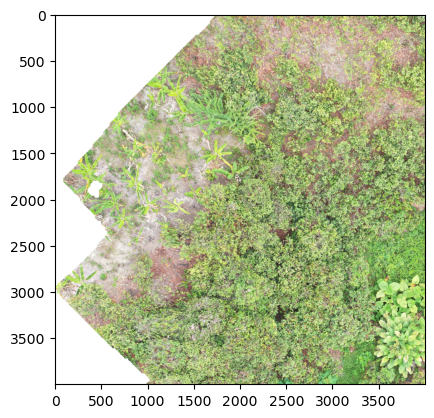

In [224]:
plt.imshow(tile1)
plt.show()

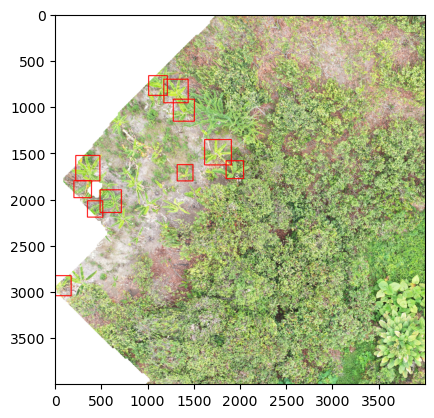

In [225]:
# See the bounding boxes
i = 0
for name in df_img1['img_path'].values:
    
    xmin = round(df_img1['xmin'].values[i])
    ymin = round(df_img1['ymin'].values[i])
    xmax = round(df_img1['xmax'].values[i])
    ymax = round(df_img1['ymax'].values[i])

    color = (255,0,0)
    
    tile1 = cv2.rectangle(tile1,(xmin,ymin),(xmax,ymax),color,10)
    
    i += 1
    #break

plt.imshow(tile1)   

In [226]:
# Function to expand a bounding box into a square
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [227]:
# Prepossing module for the images: resize, do random flips, convert to tensor and scale
preprocess = transforms.Compose([
                     transforms.Resize(224),
                     transforms.RandomHorizontalFlip(),
                     transforms.ToTensor()
])              

In [228]:
# Class to define the dataset

class Trees(Dataset):
    def __init__(self, csv_file, root_dir):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.trees_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.trees_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.trees_frame.iloc[idx, 0])
        image = Image.open(img_name)
        
        xmin = int(self.trees_frame.iloc[idx]['xmin'])
        ymin = int(self.trees_frame.iloc[idx]['ymin'])
        xmax = int(self.trees_frame.iloc[idx]['xmax'])
        ymax = int(self.trees_frame.iloc[idx]['ymax'])

        image = image.crop((xmin, ymin, xmax, ymax))
        image = expand2square(image, (0, 0, 0))
        image = preprocess(image)
        diameter = self.trees_frame.iloc[idx]['updated diameter']
        sample = image, diameter

        return sample

In [229]:
# Load the training set of bounded box images
ttrain = Trees(csv_file='mapping/train_banana.csv', root_dir='tiles/all_tiles')

In [230]:
# Load the validation set of bounded box images
tvalid = Trees(csv_file='mapping/valid_banana.csv', root_dir='tiles/all_tiles')

In [231]:
# Load the test set of bounded box images
ttest = Trees(csv_file='mapping/test_banana.csv', root_dir='tiles/all_tiles')

(array([0.54807078, 0.09307238, 0.25503559, 0.65635633, 1.08185859,
        1.04578525, 1.23518592, 1.88895044, 2.79901514, 0.39667029]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

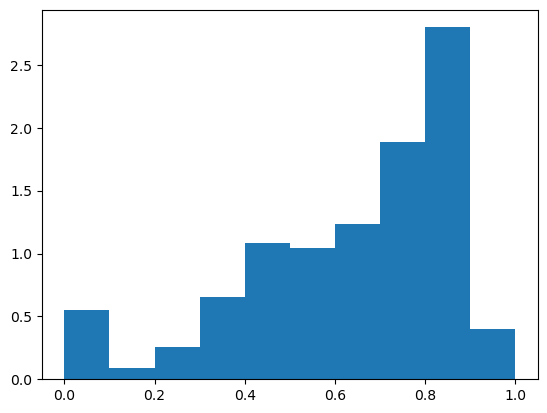

In [232]:
# Visualize how the pixel distribution of an image looks
plt.hist(ttrain[0][0].ravel(), density=True)

Diameter: 8.11688311688


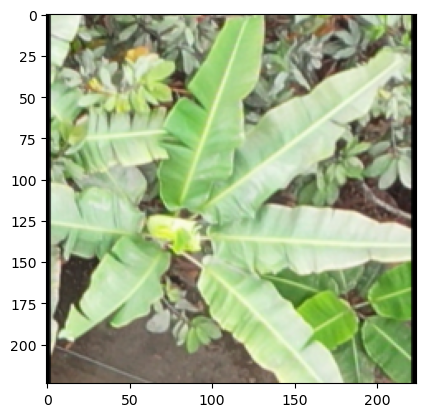

In [310]:
# Check out a training image and its label for diameter
im, label = ttrain[600]
plt.imshow(im.permute(1,2,0))
print('Diameter:',label)

Diameter: 14.6422205246


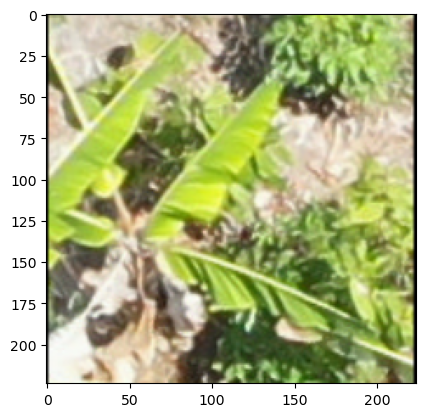

In [311]:
# Check out a validation image and its label
im, label = tvalid[180]
plt.imshow(im.permute(1,2,0))
print('Diameter:',label)

Diameter: 18.3664374841


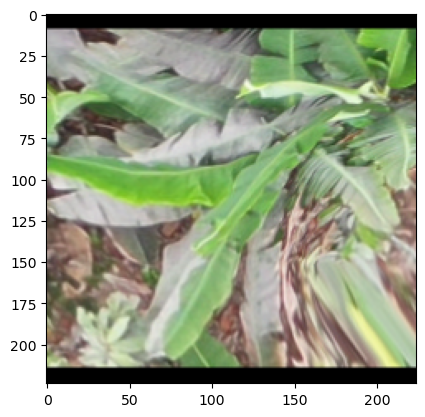

In [312]:
# Check out a test image and its label
im, label = ttest[200]
plt.imshow(im.permute(1,2,0))
print('Diameter:',label)

In [236]:
# Make sure the tensor sizes are 3*224*224
for i in range(len(ttrain)):
    sample = ttrain[i]

    print(i, sample[0].shape, sample[1])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) 12.7323656735
1 torch.Size([3, 224, 224]) 2.38731856379
2 torch.Size([3, 224, 224]) 17.5070028011
3 torch.Size([3, 224, 224]) 17.1250318309


In [ ]:
# Wrap it onto a dataloader

In [237]:
train_dataloader = DataLoader(ttrain, batch_size=64, shuffle=True)

In [238]:
valid_dataloader = DataLoader(tvalid, batch_size=64, shuffle=False)

In [239]:
test_dataloader = DataLoader(ttest, batch_size=64, shuffle=False)

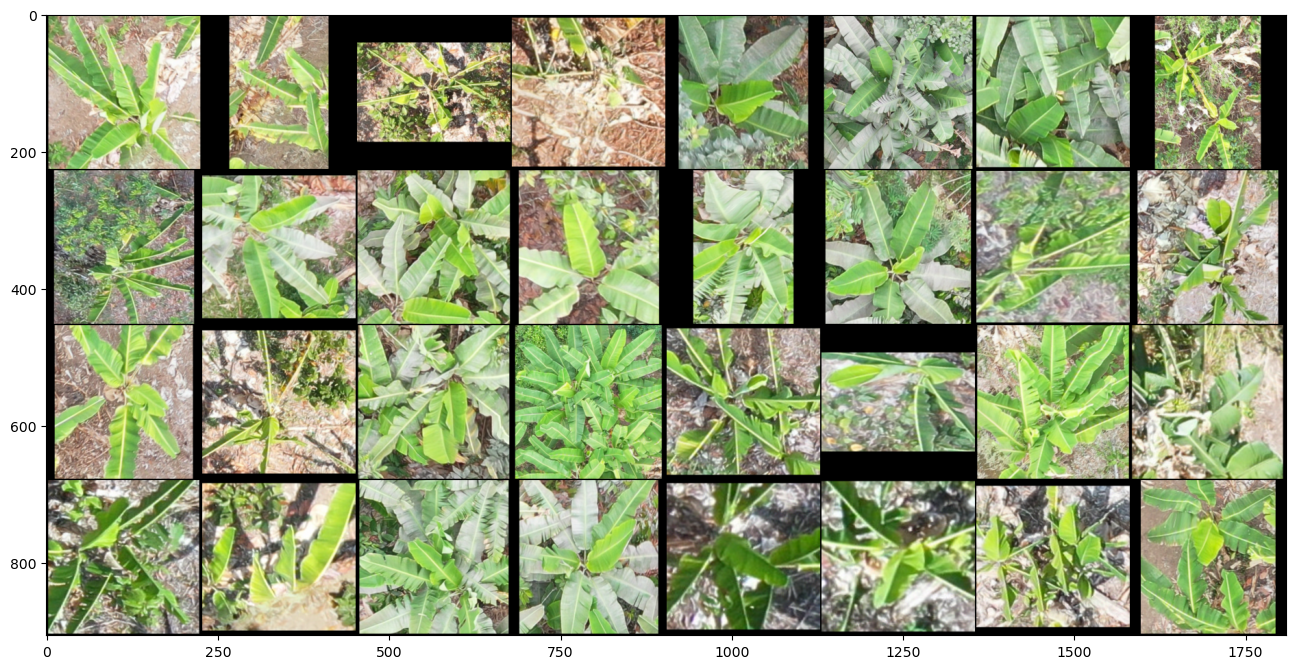

tensor([11.4273, 20.6901, 10.1859, 16.2338, 14.1648, 12.4141, 14.1011, 10.1859,
        16.8704, 10.6634, 15.5971, 16.8704, 14.0056, 12.2867, 12.7324, 12.8279,
        17.1887, 14.9605, 12.4141, 16.2338, 11.7774, 12.7324, 20.6901, 14.3239,
        12.4141,  9.5493, 14.5467, 13.1780, 15.2788, 14.6422, 14.3239, 10.1859,
        15.1197, 22.6636, 11.1408, 18.9394, 13.1462, 10.5042, 17.5070, 15.2788,
        18.0481,  9.3901, 19.8943, 10.1859,  9.0718, 17.8253, 11.7774, 15.4380,
        17.1887, 12.4141, 14.6422, 14.5467, 15.2788,  8.2760, 16.8704,  2.3873,
        17.8253, 15.9155, 10.8225, 10.5042, 11.1408, 14.7059, 10.3450, 14.9605],
       dtype=torch.float64)

In [313]:
# Check out a sample set of images
samples, labels = next(iter(train_dataloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:32])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.show()
labels

In [241]:
# What is the size of the training dataset?
print('Train dataset size:', len(ttrain))

Train dataset size: 1022


In [259]:
# Load resnet-18 model
model = models.resnet18(pretrained=True)

In [260]:
# Change the last layers of the model, include dropout to try and help with overfitting.
model.fc = nn.Sequential(
     nn.Dropout(0.5),
     nn.Linear(512, 1)
)

In [261]:
# Set the optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

In [262]:
# Set the device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the loss function
criterion = nn.MSELoss()

In [263]:
# name of the device
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [264]:
# Do the training here
train_loss = []
train_acc = []

val_loss = []
val_acc = []

epochs = 30

if torch.cuda.is_available():
    model.cuda()

for epoch in range(epochs):
      print("epoch {}/{}".format(epoch+1,epochs))
      running_loss = 0.0
      running_score = 0.0
      model.train()
      for image,label in train_dataloader:
          image, label = image.to(device), label.to(device)
          label = label.unsqueeze(1)
          optimizer.zero_grad()
          y_pred = model(image)
          loss = criterion(y_pred,label.float())  
          loss.backward() #calculate derivatives 
          optimizer.step() # update parameters
          running_loss += loss.item()
          
      epoch_loss = running_loss/len(train_dataloader)
      train_loss.append(epoch_loss)
      print("Training loss: {}".format(epoch_loss,epoch))
      
      with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          tp = 0.0 
          fp = 0.0
          fn = 0.0
          for image,label in valid_dataloader:
                image = image.to(device)
                label = label.to(device)
                label = label.unsqueeze(1)
                optimizer.zero_grad()
                y_pred = model(image)
                loss = criterion(y_pred,label.float())
                running_loss += loss.item()
        
          epoch_loss = running_loss/len(valid_dataloader)
          val_loss.append(epoch_loss)
          print("Validation loss: {}".format(epoch_loss))


epoch 1/30
Training loss: 221.03688526153564
Validation loss: 209.67087173461914
epoch 2/30
Training loss: 195.36026191711426
Validation loss: 193.50318145751953
epoch 3/30
Training loss: 170.0305061340332
Validation loss: 172.45778274536133
epoch 4/30
Training loss: 138.95495557785034
Validation loss: 142.9290428161621
epoch 5/30
Training loss: 106.33973217010498
Validation loss: 96.74474334716797
epoch 6/30
Training loss: 91.37040281295776
Validation loss: 92.8242130279541
epoch 7/30
Training loss: 76.46584868431091
Validation loss: 67.18927001953125
epoch 8/30
Training loss: 62.1728618144989
Validation loss: 59.3876371383667
epoch 9/30
Training loss: 52.682069301605225
Validation loss: 61.20042610168457
epoch 10/30
Training loss: 43.75532817840576
Validation loss: 53.5083589553833
epoch 11/30
Training loss: 36.51598048210144
Validation loss: 42.24178504943848
epoch 12/30
Training loss: 30.863134741783142
Validation loss: 41.64157581329346
epoch 13/30
Training loss: 26.01037716865539

In [265]:
epochs = range(1, 31, 1)

In [266]:
train_loss, val_loss

([221.03688526153564,
  195.36026191711426,
  170.0305061340332,
  138.95495557785034,
  106.33973217010498,
  91.37040281295776,
  76.46584868431091,
  62.1728618144989,
  52.682069301605225,
  43.75532817840576,
  36.51598048210144,
  30.863134741783142,
  26.010377168655396,
  22.14872920513153,
  17.683054864406586,
  14.177614629268646,
  11.595528185367584,
  9.959415972232819,
  7.866317480802536,
  6.775229424238205,
  5.835766822099686,
  4.537945374846458,
  4.194349512457848,
  3.541335828602314,
  3.401406727731228,
  3.3002383783459663,
  2.7509494349360466,
  2.83744640648365,
  2.4168814048171043,
  2.2787121385335922],
 [209.67087173461914,
  193.50318145751953,
  172.45778274536133,
  142.9290428161621,
  96.74474334716797,
  92.8242130279541,
  67.18927001953125,
  59.3876371383667,
  61.20042610168457,
  53.5083589553833,
  42.24178504943848,
  41.64157581329346,
  40.99587059020996,
  37.92642593383789,
  24.335278034210205,
  23.19999361038208,
  26.998706817626953

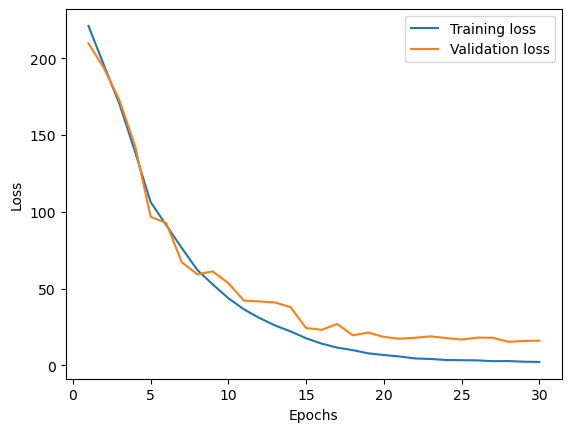

In [267]:
plt.plot(epochs, train_loss, label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [268]:
torch.save(model.state_dict(), 'resnet18-diameter-30epochs_lr1e-4.pt')

In [270]:
# Predictions on the test set
test_loss = []
y_label = []
y_predict = []

with torch.no_grad():
          model.eval()
          running_loss = 0.0
          for image,label in test_dataloader:
                image = image.to(device)
                label = label.to(device)
                label = label.unsqueeze(1)
                optimizer.zero_grad()
                y_pred = model(image)

                loss = criterion(y_pred,label.float())
                running_loss += loss.item()

                np_true = torch.clone(label)
                np_predicted = torch.clone(y_pred)
                y_label.extend(np_true.cpu().numpy())
                y_predict.extend(np_predicted.cpu().numpy())
          
          epoch_loss = running_loss/len(test_dataloader)
          test_loss.append(epoch_loss)
          print("Test loss: {}".format(epoch_loss))

Test loss: 18.029460906982422


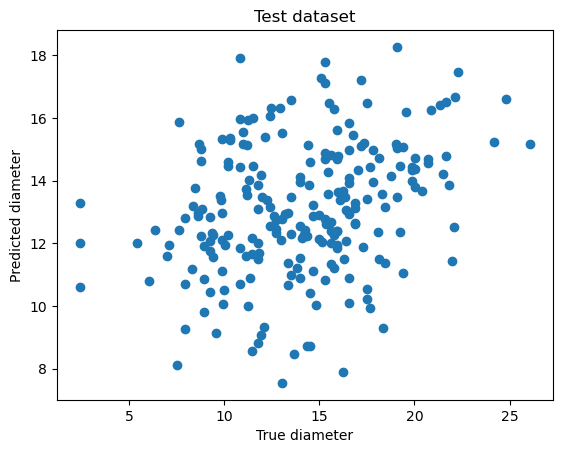

In [276]:
plt.scatter(y_label, y_predict)
plt.xlabel('True diameter')
plt.ylabel('Predicted diameter')
plt.title('Test dataset')
plt.show()

In [275]:
# Predictions on the validation set
validation_loss = []
y_label_valid = []
y_predict_valid = []

with torch.no_grad():
          model.eval()
          running_loss = 0.0
          for image,label in valid_dataloader:
                image = image.to(device)
                label = label.to(device)
                label = label.unsqueeze(1)
                optimizer.zero_grad()
                y_pred = model(image)

                loss = criterion(y_pred,label.float())
                running_loss += loss.item()

                np_true = torch.clone(label)
                np_predicted = torch.clone(y_pred)
                y_label_valid.extend(np_true.cpu().numpy())
                y_predict_valid.extend(np_predicted.cpu().numpy())
          
          epoch_loss = running_loss/len(valid_dataloader)
          validation_loss.append(epoch_loss)
          print("Valid loss: {}".format(epoch_loss))

Valid loss: 16.909778118133545


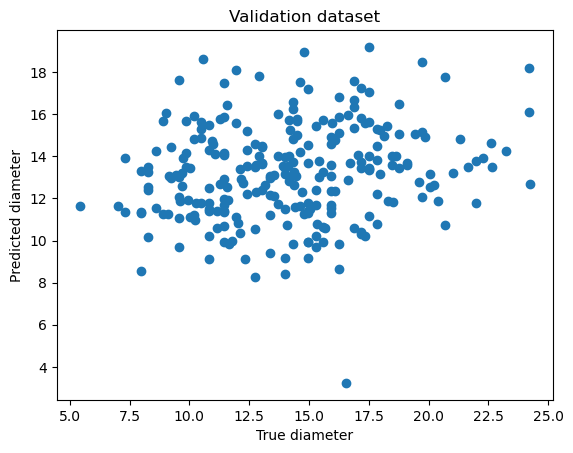

In [277]:
plt.scatter(y_label_valid, y_predict_valid)
plt.xlabel('True diameter')
plt.ylabel('Predicted diameter')
plt.title('Validation dataset')
plt.show()

In [278]:
# Predictions on the training set
train_loss = []
y_label_train = []
y_predict_train = []

with torch.no_grad():
          model.eval()
          running_loss = 0.0
          for image,label in train_dataloader:
                image = image.to(device)
                label = label.to(device)
                label = label.unsqueeze(1)
                optimizer.zero_grad()
                y_pred = model(image)

                loss = criterion(y_pred,label.float())
                running_loss += loss.item()

                np_true = torch.clone(label)
                np_predicted = torch.clone(y_pred)
                y_label_train.extend(np_true.cpu().numpy())
                y_predict_train.extend(np_predicted.cpu().numpy())
          
          epoch_loss = running_loss/len(train_dataloader)
          train_loss.append(epoch_loss)
          print("Train loss: {}".format(epoch_loss))

Train loss: 1.6963265761733055


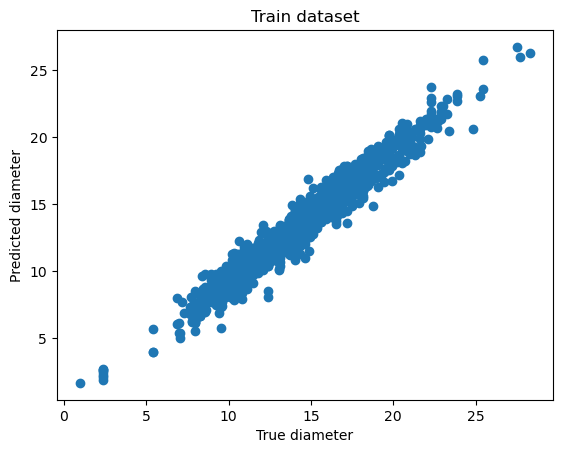

In [279]:
plt.scatter(y_label_train, y_predict_train)
plt.xlabel('True diameter')
plt.ylabel('Predicted diameter')
plt.title('Train dataset')
plt.show()

In [281]:
y_label_full = y_label + y_label_valid + y_label_train

In [282]:
y_pred_full = y_predict + y_predict_valid + y_predict_train

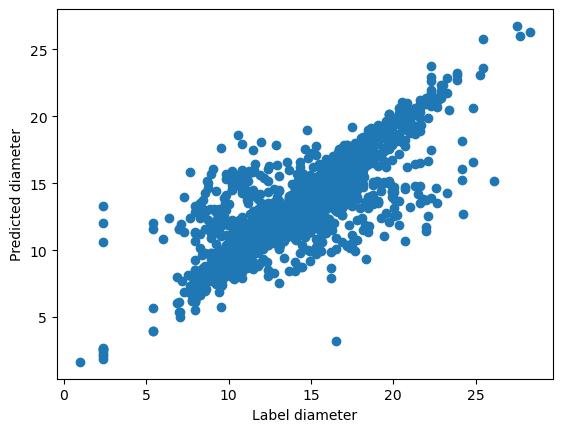

In [284]:
plt.scatter(y_label_full, y_pred_full)
plt.xlabel('Label diameter')
plt.ylabel('Predicted diameter')
plt.show()

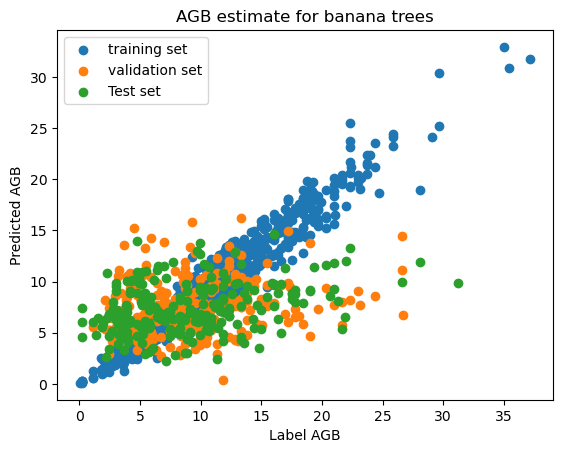

In [294]:
plt.scatter(np.array(y_label_train)**2.13 * 0.03, np.array(y_predict_train)**2.13 * 0.03, label = 'training set')
plt.scatter(np.array(y_label_valid)**2.13 * 0.03, np.array(y_predict_valid)**2.13 * 0.03, label = 'validation set')
plt.scatter(np.array(y_label)**2.13 * 0.03, np.array(y_predict)**2.13 * 0.03, label = 'Test set')
plt.xlabel('Label AGB')
plt.ylabel('Predicted AGB')
plt.title('AGB estimate for banana trees')
plt.legend()
plt.show()